# Start

This notebook assumes that the user is a student at Minnesota State University Moorhead for the purposes of obtaining data. If this is not the case, please download your data as usual from wherever you get it and return here.

Reduction will not be included here. There is a separate notebook containing the Python package 'Reducer' that is professional and easy to use. Reducer is itself based off of the Python package 'CCDProc'. 

Documentation for Reducer can be found here: http://reducer.readthedocs.io/en/latest/#. 

Documentation for CCDProc can be found here: http://ccdproc.readthedocs.io/en/latest/

This guide was compiled by Andy Block, although at this time,I have written very little of the code.

The first step in this process is to obtain reduced images. Once this is done, work can really begin.

# Combination

Image combination can be quite intense on your computer. Personally, I sort my images by filter. This usually ensures that there are few enough images that your computer will be safe. Combination can also take a fair amount of time to complete. It takes my computer roughly 30 minutes to combine 100 images in one filter. Be patient. If your computer cannot handle the intensity, see the notes at the end of this notebook. If you choose to do one filter at a time, you will very obviously have to run the combination code several times.

# Combination Code

In [1]:
from __future__ import print_function, division

import os

import numpy as np

from astropy.coordinates import SkyCoord, Angle
from astropy.io import fits
from astropy.table import Table, Column
from astropy.wcs import WCS
from astropy import units as u


from ccdproc import CCDData, Combiner, combine

from reproject import reproject_interp
from msumastro import ImageFileCollection

import sep

import matplotlib.pyplot as plt

import csv

import msumastro



%matplotlib inline

# Begin Combination Code

Open an image from the night you wish to combine and note four combinations of coordinates. Each combination should be one part of a rectangle. This is the hardest part of combination, mainly because you have to go back and forth a lot between your image viewer and the notebook.

In [2]:
# Region to use for sky background
# Top left corner:
top_left = SkyCoord("hms dms") #Give the RA and DEC taken from two rectangles in two images.
bottom_right = SkyCoord("hms dms")
# mean was -21.94

# the other rectangle
top_left = SkyCoord("hms dms")
bottom_right = SkyCoord("hms dms")
# mean -20.892

Load your images. Note that if you copy/paste the address you will have to change the forward slashes to back slashes (If using a flavor of Windows).

In [3]:
image_dir = 'Insert Path Here'
ic = ImageFileCollection(image_dir, keywords='*')

Set your filters. If you are doing combination of more than one filter type at once, simply add them as needed. I have found that doing more than one filter at once is a bit too intense. If you have one badass computer, then go for it.

In [4]:
filters = ['Insert Filter(s) here']

Ensure that the images you loaded are correct. Make sure that the filter and object name are correct. Check the fits header if you are unsure.

In [6]:
# Use the middle image as the reference WCS

files = ic.files_filtered(filter='Insert Filter(s) here', object='Insert Object Here')
files

array(['Mette_0005_RGB_R.fit', 'Mette_0006_RGB_R.fit',
       'Mette_0007_RGB_R.fit', 'Mette_0008_RGB_R.fit',
       'Mette_0009_RGB_R.fit', 'Mette_0010_RGB_R.fit',
       'Mette_0011_RGB_R.fit', 'Mette_0012_RGB_R.fit',
       'Mette_0013_RGB_R.fit', 'Mette_0014_RGB_R.fit',
       'Mette_0015_RGB_R.fit', 'Mette_0016_RGB_R.fit',
       'Mette_0017_RGB_R.fit', 'Mette_0018_RGB_R.fit',
       'Mette_0019_RGB_R.fit', 'Mette_0020_RGB_R.fit'], 
      dtype='|S20')

In [7]:
ref_file = files[len(files)//2]
reference_image = fits.getheader(os.path.join(ic.location, ref_file))

This is the cell that is the most intensive on your computer and takes the most time. Again, be patient. This adjusts all your images such that they are aligned with each other. Make sure you create a new folder for these images and point the save location at it. This helps keep you organized.

In [9]:
for filt in filters:
    for hdu in ic.hdus(filter=filt, object='Insert Object Here', save_location='Insert Save Location Here'):
        new_data, footprint = reproject_interp(hdu, reference_image)
        hdu.data = new_data

NotImplementedError: Currently only data with a WCS that includes a celestial component can be reprojected

In [ ]:
ic_new = ImageFileCollection('Insert Save Location Here', keywords='*')

The function below is what actually does the combination. Be sure to change ic_new to the same path as the save_location, unless you have the adjusted images saved elsewhere, which I advise against.

In [ ]:
def combine_filter(image_collection, filter=None):
    ccd_list = []
    for hdu in ic_new.hdus(filter=filter):
        masked_data = np.ma.array(hdu.data, mask=np.isnan(hdu.data))
        med = np.ma.median(masked_data)
        print(med)
        ccd_list.append(CCDData(hdu.data - med, meta=hdu.header, unit='adu', mask=np.isnan(hdu.data)))
    c = Combiner(ccd_list)
    foo = c.average_combine()
    return foo

The loop below actually makes the combined image from the adjusted images. It is saved in the same location as the notebook, so keep that in mind. If you give the loop too many images, this part could also take some time. My computer has crashed several times because I fed in too many images. I find that my computer can handle around 70 images before giving up.

In [ ]:
for filt in filters:
    combined_image = combine_filter(ic_new, filter=filt)
    combined_image.header['filter'] = filt
    combined_image.write(filt + '_combined.fit')

# End Combination Code

At the end of all of this, you should have a folder full of adjusted images and some combined images. Here you have a choice. You can either do image subtraction or source detection. At this point, neither are completely finished, although both are in a state such that you could get something from them.

# Subtraction

In its current form, this code takes your adjusted images and subtracts the combined image from them. This results in some ugly images. Over time, this will be improved upon, but it's what you get for now. This code should be run once for each filter.

# Begin Subtraction Code

Your first step is to load your directory of adjusted fits files, like so:

In [3]:
ic_sub = ImageFileCollection('Insert Path Here', keywords = '*')

You will also want to load in the combined image. Note that you can specify a full path name and not just a file name. I highly recommend specifying a path name, as just using a file name requires that the notebook and file be in the same directory. This can create issues, so avoid it whenever possible.

In [4]:
data = fits.getdata('Insert Path Here')
data = data.byteswap(True).newbyteorder()

The subtraction is straightforward enough. Be sure that the save location is changed to the appropriate directory. Also be sure to change the object name as needed.

In [7]:
for hdu in ic_sub.hdus(object='2005 yu55', save_location='Insert Path Here', save_with_name = '_subtracted'):
    sub_image = hdu.data - data
    hdu.data = sub_image

In [8]:
save_location='Insert Path Here'
images = msumastro.ImageFileCollection(location=save_location, keywords='*')

In [10]:
tt = msumastro.TableTree(images.summary_info, ['exposure'], 'file')
fits_browser = ImageBrowser(tt, demo=False, directory=save_location)
fits_browser.display()
fits_browser.padding = '10px'

NameError: name 'ImageBrowser' is not defined

# End Subtraction Code

Images created by the subtraction code are not super pretty or useful right now. My hope is that this will change in the near future.

# Source Detection

Source detection is what will turn out to be one of the more important steps in this process. Currently, it can return a coordinate list, but I'm still working on some of the implementation.

# Begin Source Detection Code

Again, you should really change the file name to a full path. You will be significantly more organized if you do, I promise. This just loads in the data. Nothing fancy

In [3]:
data2 = fits.getdata('Insert Path Here')
data2 = data2.byteswap(True).newbyteorder()

Uses the package 'SEP' to do some calculations involving the image background.

In [4]:
# Measure a spatially variable background of some image data
# (a numpy array)
bkg = sep.Background(data2)

# Evaluate the spatially variable background:
back = bkg.back()  # creates an array, same shape and type as data

# Evaluate the spatially variable RMS of the background:
rms = bkg.rms()  # creates an array, same shape and type as data

# Directly subtract the background from the data in place
bkg.subfrom(data2)

bkg.globalback  # Global "average" background level
bkg.globalrms  # Global "average" RMS of background

89.43848419189453

Shows the image you will be finding sources in. Not absilutely necessary, but I like being able to see what I'm working with. When displaying images it is handy to set the minimum (black) and maximum (white) values to a few times the RMS background.

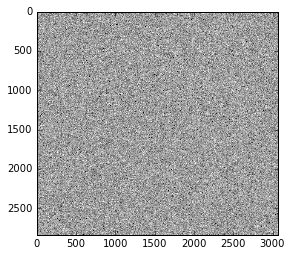

In [5]:
plt.imshow(data2, cmap='gray', vmin=-5*bkg.globalrms, vmax=3*bkg.globalrms)

Detect objects in the image and output a value for the number of objects detected. You should check your image to see if the value seems reasonable. 

In [6]:
thresh = 5 * bkg.globalrms
objects = sep.extract(data2, thresh)

len(objects)

10

The function below basically just makes two plots. One is your image and the other is circles that will be put around each detected source.

In [7]:
def plot(object1,datas):
    
    flux, fluxerr, flag = sep.sum_circle(datas, object1['x'], object1['y'], 16.0, bkgann=(20., 30.))
    
    good_flux = flux > 0
    plt.figure(figsize=(30, 30))

    mean_flux = flux[good_flux].mean()

    plt.imshow(data2, cmap='gray', vmin=-3*bkg.globalrms, vmax=3*bkg.globalrms)
    plt.scatter(objects['x'][good_flux], objects['y'][good_flux], marker='o', s=200*np.sqrt(flux[good_flux]/mean_flux),
               facecolor = 'none',edgecolor = 'magenta', lw=2)
    #plt.savefig('C:/Users/Andy-PC/Documents/Research/Combined Images/7-20-15combined/SrcDetectedImages/7-20-15/I Filter')
    
    return flux

Plot the source detected image, along with the flux. May or may not be important.

array([  8156.43998177,  25361.51237914,  10749.62067021,  15545.61909932,
        22436.97740668,  -3147.09795941,    322.11060819,  24726.95965899,
        24501.83395557,  -9290.74457009])

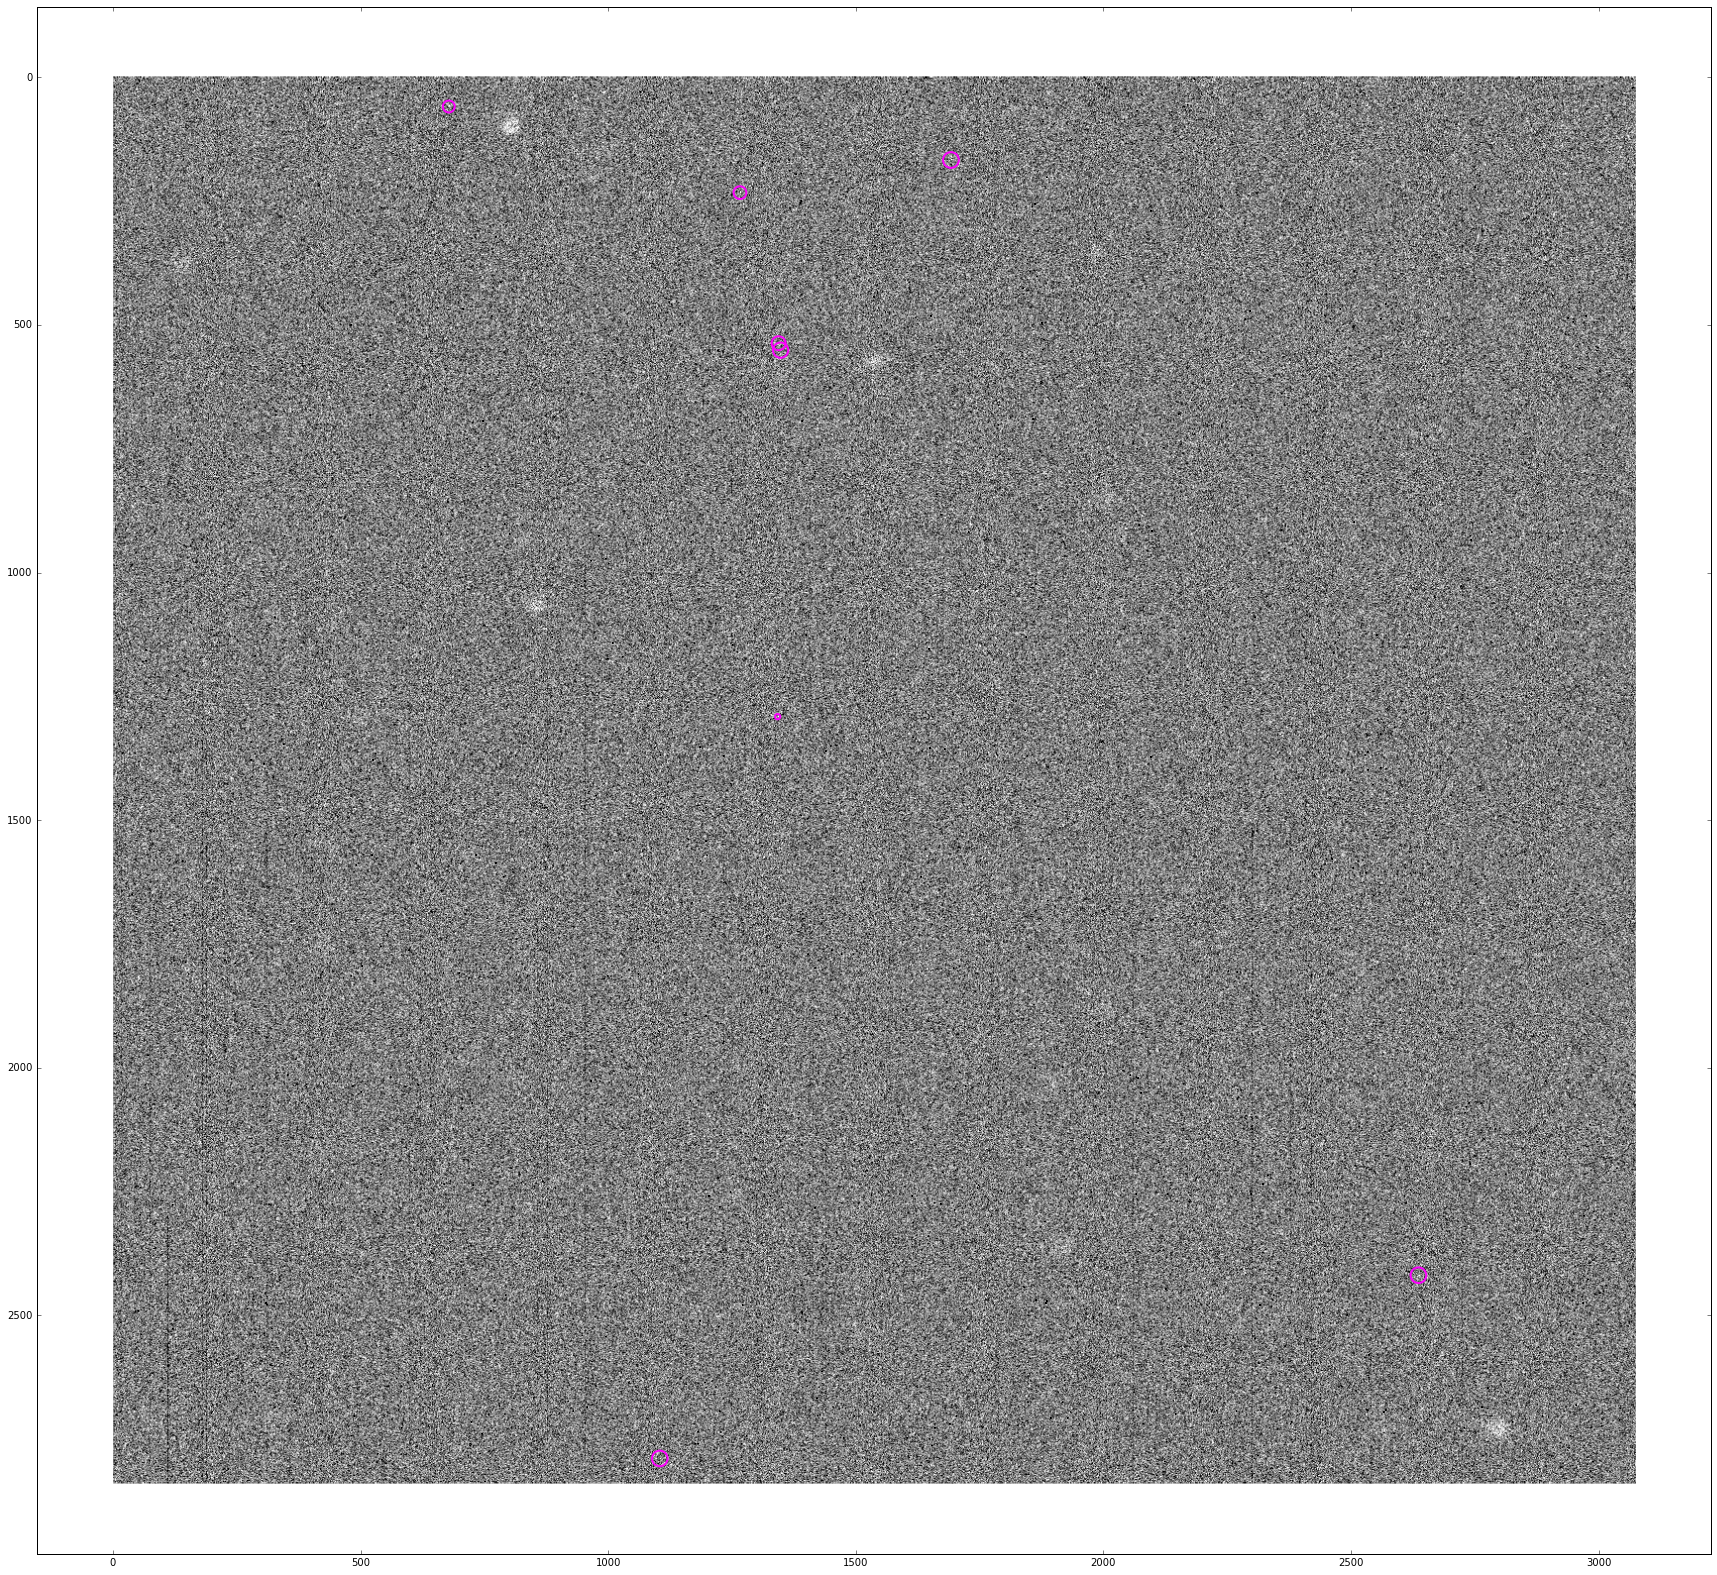

In [8]:
plot(objects,data2)

From this, we want the coordinates of the detected objects. Do that like this: (Again, specify a path)

In [8]:
header = fits.getheader('Insert Path Here')
wcs = WCS(header=header)

ra_decs = wcs.all_pix2world(objects['x'], objects['y'], 0)

In [9]:
for ra, dec in zip(ra_decs[0], ra_decs[1]):
    ra_angle = Angle(ra * u.degree)
    dec_angle = Angle(dec * u.degree)


    print(','.join([ra_angle.to_string(unit=u.hour, sep=':'), dec_angle.to_string(unit=u.degree, sep=':'),'1','1']))

42:57:08.3794,15:59:02.8407,1,1
173:39:42.3617,20:40:05.1518,1,1
116:46:00.5791,28:18:29.6742,1,1
19:23:57.0629,110:31:11.6032,1,1
165:47:02.0601,108:33:22.5935,1,1
101:43:50.0656,113:39:04.6763,1,1
144:36:24.2222,172:12:33.9384,1,1
148:31:32.3835,184:10:07.1931,1,1
0:06:10.9702,209:51:13.6972,1,1
21:12:11.3923,235:30:02.077,1,1
0:05:28.0709,238:51:32.8312,1,1
74:14:39.2656,246:22:55.4539,1,1
76:45:26.2709,249:01:49.3934,1,1
30:20:22.556,282:57:49.3692,1,1
141:33:37.7848,305:48:11.0791,1,1
71:42:04.9939,330:45:38.3598,1,1
91:02:47.5893,337:23:53.999,1,1
107:20:44.0143,364:05:50.275,1,1
0:06:04.5326,382:04:49.7948,1,1
141:16:19.1817,443:19:28.3583,1,1
86:03:36.6029,473:06:05.1541,1,1
0:04:35.0777,483:19:43.3924,1,1
2:47:57.3961,491:47:42.6766,1,1
203:24:02.6871,531:00:13.7118,1,1
40:48:42.4304,534:06:24.6844,1,1
2:36:34.5641,539:53:14.428,1,1
127:49:16.2153,556:29:01.6008,1,1
139:49:04.0831,561:59:46.7351,1,1
50:33:56.9797,613:38:42.3751,1,1
76:11:08.6224,613:34:52.637,1,1
165:47:46.889

## Make a CSV containing RA, DEC, and flux

In [10]:
flux, fluxerr, flag = sep.sum_circle(data2, objects['x'], objects['y'], 16.0, bkgann=(20., 30.))


In [28]:
object_table = Table()

# separate RA column
ra_column = Column(data=ra_decs[0], unit='degree', name='RA')
object_table.add_column(ra_column)  # add RA column to table
# separate Dec column
dec_column = Column(data=ra_decs[1], unit='degree', name='Dec')
object_table.add_column(dec_column)  # add Dec column to table
# separate flux column
flux_column = Column(data=flux, unit='Wm^-2', name='Flux')
object_table.add_column(flux_column)



In [29]:
good_flux = object_table['Flux'] > 0
object_table = object_table[good_flux]

## Make a fits file from the CSV

In [40]:
object_table.write('RADEC', format = 'fits')

# End Source Detection Code

# Notes

Documentation for the various packages used in the above codes. Reducer and CCDProc documentation is above.

Astropy: http://docs.astropy.org/en/stable/

SEP: http://sep.readthedocs.io/en/v0.5.x/index.html

Matplotlib: http://matplotlib.org/contents.html

Reproject: http://reproject.readthedocs.io/en/stable/

msumastro: http://msum-astro.readthedocs.io/en/latest/

If you run into any issues, I'd start by taking a look at the documentation. If it's too much arcane BS, come find me. I've run into many errors in most of these packages, and have some idea of how to fix a good handful. Additionally, while compiling all of the code, I may have broken something, so that's on me. If I am of no help, find Dr. Craig. He's familiar enough with most of the code and should be able to help. He's usually pretty busy, so try him last.